# Imports

In [9]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast

from tqdm.auto import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Loading Data 

In [10]:
# Load the CSV files
train_df = pd.read_csv('dataset/csvs/train_df.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

In [11]:
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,target_list,class_label
0,3204,62,Male,3204_left.jpg,3204_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3204_left.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",0
1,1410,69,Female,1410_left.jpg,1410_right.jpg,suspected glaucoma，refractive media opacity,mild nonproliferative retinopathy,0,1,1,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",1410_left.jpg,"[0, 0, 1, 0, 0, 0, 0, 0]",2
2,3144,56,Female,3144_left.jpg,3144_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3144_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",0
3,2717,59,Male,2717_left.jpg,2717_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2717_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",0
4,4026,55,Male,4026_left.jpg,4026_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4026_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",1


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

Class N: 1838
Class D: 1029
Class G: 182
Class C: 187
Class A: 170
Class H: 82
Class M: 149
Class O: 453


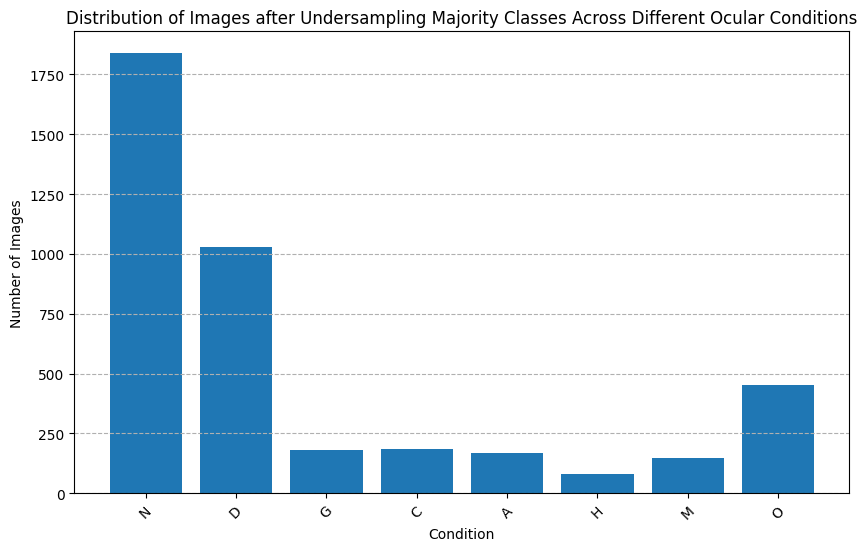

In [12]:
# Convert string representation of list to actual list using ast.literal_eval
train_df['target'] = train_df['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in train_df['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(train_df['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Undersampling Majority Classes Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')


# Undersampling the Majority Classes
- Diabetes and Normal to 1000 images 

In [13]:
import pandas as pd
from sklearn.utils import resample


def undersample_majority_class(df, majority_index=0, desired_samples=500):
    """
    This function undersamples the majority class in the dataframe where the 'target' column is a list.
    df: Your dataframe.
    majority_index: The index in the 'target' list that corresponds to the majority class.
    desired_samples: The number of samples to undersample to.
    """
    # Convert the 'target' string representation of a list to an actual list
    df['target_list'] = df['target']
    
    # Filter the majority class
    majority_class_df = df[df['target_list'].apply(lambda x: x[majority_index] == 1)]
    
    # Check if the desired number of samples is greater than the number of samples in the majority class
    if desired_samples > len(majority_class_df):
        desired_samples = len(majority_class_df)  # Set desired_samples to the number of samples in the majority class
    
    # Undersample the majority class to the desired number of samples
    majority_class_undersampled = resample(majority_class_df,
                                           replace=False,  # sample without replacement
                                           n_samples=desired_samples,  # to match minority class
                                           random_state=123)  # for reproducible results
    
    # Remove the original majority class samples from the dataframe
    df = df[df['target_list'].apply(lambda x: x[majority_index] == 0)]
    
    # Concatenate the undersampled dataframe with the remaining data
    df = pd.concat([df, majority_class_undersampled], axis=0)
    
    # Clean up: Remove the 'target_list' column if no longer needed
    df.drop('target_list', axis=1, inplace=True)
    
    return df

# Usage example:
# Assuming 'target' at index 0 represents the 'Normal' class and we want to undersample to 1000 samples
new_df = undersample_majority_class(train_df, majority_index=0, desired_samples=1000)
new_df = undersample_majority_class(new_df, majority_index=1, desired_samples=1000)


Class N: 1000
Class D: 1000
Class G: 182
Class C: 187
Class A: 170
Class H: 82
Class M: 149
Class O: 453


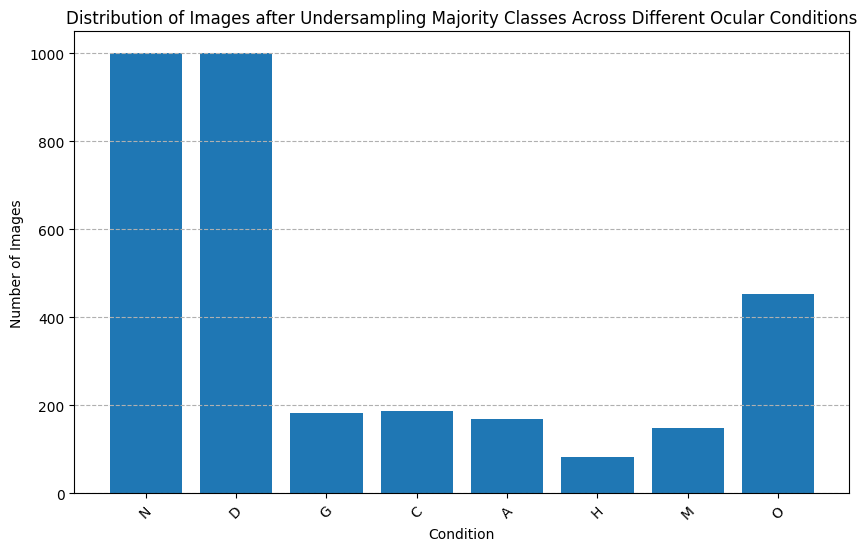

In [14]:
# Convert string representation of list to actual list using ast.literal_eval
new_df['target'] = new_df['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in new_df['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(new_df['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Undersampling Majority Classes Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [15]:
# Assuming 'class_distribution' is a dictionary with your class labels and counts
target_sample_count = max(class_distribution_dict.values()) 

augmentations_needed = {
    class_label: target_sample_count - count 
    for class_label, count in class_distribution_dict.items() if count < target_sample_count
}

# Calculate the number of augmentations needed per existing sample
augmentations_per_sample = {
    class_label: (augmentations_needed[class_label] // count) + 1  # Adding 1 for at least one augmentation
    for class_label, count in class_distribution_dict.items() if class_label in augmentations_needed
}

print(augmentations_per_sample)

{'G': 5, 'C': 5, 'A': 5, 'H': 12, 'M': 6, 'O': 2}


In [ ]:
# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    brightness_range=[0.8, 1.2],
    fill_mode="constant",
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

augmentations_needed = {   # Doubling augementations needed for all classes
    0 : 0,  # Normal
    1 : 0,  # Diabetes 
    2 : 5,  # Glaucoma
    3 : 5,  # Cataract
    4 : 5,  # AMD
    5 : 12, # Hypertension
    6 : 6,  # Myopia
    7 : 2   # Other Diseases + 1
}

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    # Original image path
    img_path = os.path.join('dataset/preprocessed_images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []
    
    # Determine the maximum number of augmentations needed
    targets = row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])
    
    # Save the original image to the new directory with a prefix to indicate it's original
    original_filename = f"original_{row['filename']}"
    original_save_path = os.path.join(save_directory, original_filename)
    img.save(original_save_path)  # Save the original image
    
    # Update the row for the original image and add to the augmented rows list
    original_row = row.copy()
    original_row['filename'] = original_filename
    augmented_rows.append(original_row)
    
    if max_augmentations_needed > 0:
        # Generate and save augmented images
        for i in range(max_augmentations_needed):
            # Manual save for more control over filenames
            augmented_img = next(augmentation.flow(x, batch_size=1))[0]  # Get one sample
            augmented_img = Image.fromarray(np.uint8(augmented_img))  # Convert to PIL Image to save
            unique_filename = f'aug_{i}_{row["filename"]}'
            save_path = os.path.join(save_directory, unique_filename)
            augmented_img.save(save_path)  # Save the augmented image
            
            # Update row for augmented image and add to the list
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)
    
    return augmented_rows

# Usage with ThreadPoolExecutor, assuming df_train_final is your DataFrame to process
augmented_data = []

with ThreadPoolExecutor(max_workers=8) as executor:
    tasks = []
    for _, row in new_df.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with both original and augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Assuming df_train_final and the necessary libraries are correctly defined
df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv('dataset/csvs/augmented.csv', index=False)

In [17]:
df_augmented = pd.read_csv('dataset/csvs/augmented.csv')

In [18]:
# check the augmented data
df_augmented.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,class_label
0,461,62,Female,461_left.jpg,461_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",original_461_right.jpg,7
1,461,62,Female,461_left.jpg,461_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",aug_0_461_right.jpg,7
2,461,62,Female,461_left.jpg,461_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",aug_1_461_right.jpg,7
3,170,59,Male,170_left.jpg,170_right.jpg,vitreous degeneration,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",original_170_left.jpg,7
4,170,59,Male,170_left.jpg,170_right.jpg,vitreous degeneration,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",aug_0_170_left.jpg,7


Class N: 1000
Class D: 1000
Class G: 1092
Class C: 1122
Class A: 1020
Class H: 1066
Class M: 1043
Class O: 1359


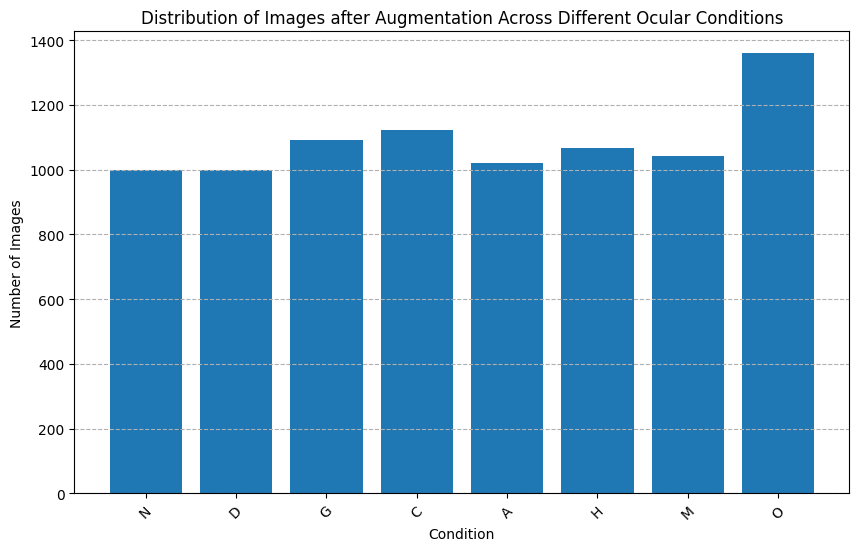

In [19]:


# Convert string representation of list to actual list using ast.literal_eval
df_augmented['target'] = df_augmented['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_augmented['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_augmented['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
